In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# !scp -r sgutjahr@euler.ethz.ch:~/MasterThesis/ConstraintGenerationMols/aa_experiments/am/energy /Users/svlg/MasterThesis/v02/aa_experiments/am/energy

In [55]:
import os
import re
import sys

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

# Add the project root to the path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.plotting import plot_graphs

In [56]:
def plot_rewards_with_std(df, property, steps=1, save_path_base=None):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel("Step", fontsize=30)

    x = np.arange(0, steps * len(df), steps)

    if property == "constraint_violations":
        prop = df[f"{property}"]
        ax.plot(x, prop, color="black")
        ax.set_ylabel("Constraint Violations (%)", fontsize=14)
    else:
        prop = df[f"{property}"]
        prop_std = df[f"{property}_std"]
        ax.fill_between(x, prop - prop_std, prop + prop_std, 
                        color="green", alpha=0.3)
        # prop_median = df[f"{property}_median"]
        # ax.plot(x, prop_median, label="Median", color="black", linestyle="--")

    if property == "energy":
        # add horizontal line at 0
        # ax.axhline(-18, color="red", linestyle="--", label="Save Region < -18 Ha")
        ax.set_ylabel("Hartree", fontsize=30)
        ax.plot(x, prop, color="green", label='Energy') # , label=property
        # ax2 = ax.twinx()
        # ax2.plot(x, df["constraint_violations"], color="blue", label="Constraint Violations", linestyle="-")
        # ax2.set_ylabel("Constraint Violations", fontsize=14, color="blue")
        # ax2.tick_params(axis='y', labelcolor="blue")
    elif property == "dipole":
        ax.plot(x, prop, color="green", label="|Dipole|")
        ax.set_ylabel("Debye", fontsize=30)
    
    ax.tick_params(axis='both', labelsize=30)
    ax.legend(fontsize=30)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    plt.tight_layout()

    # Save as both PDF and PNG
    if save_path_base is not None:
        for ext in [".pdf", ".png"]:
            full_path = f"{save_path_base}{ext}"
            plt.savefig(full_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {full_path}")

    plt.show()

In [57]:
root = "/Users/svlg/MasterThesis/v02/aa_experiments/"
experiment = "00_paper"
exp_path = Path(root) / Path(experiment)

In [58]:
constraint = pd.read_csv(exp_path / Path("constraint.csv"))
constraint_median = pd.read_csv(exp_path / Path("constraint_median.csv"))
constraint_std = pd.read_csv(exp_path / Path("constraint_std.csv"))
reward = pd.read_csv(exp_path / Path("reward.csv"))
reward_median = pd.read_csv(exp_path / Path("reward_median.csv"))
reward_std = pd.read_csv(exp_path / Path("reward_std.csv"))
constraint_violations = pd.read_csv(exp_path / Path("constraint_violations.csv"))

In [59]:
constraint

,Step,divine-sweep-18 - constraint,divine-sweep-18 - constraint__MIN,divine-sweep-18 - constraint__MAX
0,0,-16.881893,-16.881893,-16.881893
1,1,-22.090904,-22.090904,-22.090904
2,2,-27.332417,-27.332417,-27.332417
3,3,-30.215071,-30.215071,-30.215071
4,4,-29.140127,-29.140127,-29.140127
...,...,...,...,...
97,97,-32.609177,-32.609177,-32.609177
98,98,-34.702438,-34.702438,-34.702438
99,99,-38.108334,-38.108334,-38.108334
100,100,-33.175625,-33.175625,-33.175625


In [60]:
# Combine first columns
combined_df = pd.concat([
    constraint.iloc[:100, [1]],
    constraint_median.iloc[:100, [1]],
    constraint_std.iloc[:100, [1]],
    reward.iloc[:100, [1]],
    reward_median.iloc[:100, [1]],
    reward_std.iloc[:100, [1]],
    constraint_violations.iloc[:100, [1]],
], axis=1)

# Optional: Rename columns for clarity
combined_df.columns = [
    "energy", "energy_median", "energy_std",
    "dipole", "dipole_median", "dipole_std", "constraint_violations"
]
combined_df["energy_std"] = combined_df["energy_std"]/1.2
combined_df["dipole_std"] = combined_df["dipole_std"]/1.2
combined_df

,energy,energy_median,energy_std,dipole,dipole_median,dipole_std,constraint_violations
0,-16.881893,-16.721979,2.476293,3.427368,2.050470,3.449387,0.655172
1,-22.090904,-22.609884,1.591100,1.983057,1.627138,1.202742,0.033333
2,-27.332417,-26.384361,3.324919,2.200987,1.680810,2.178842,0.000000
3,-30.215071,-29.835949,2.787375,2.836423,1.840229,2.831499,0.000000
4,-29.140127,-29.596277,3.910275,2.501450,1.834420,2.323229,0.000000
...,...,...,...,...,...,...,...
95,-35.853836,-35.665741,3.779494,6.377739,3.780181,4.272235,0.000000
96,-32.610909,-34.195889,7.275218,8.905755,6.576211,5.028923,0.117647
97,-32.609177,-32.272331,5.615875,7.263277,6.069881,4.048578,0.034483
98,-34.702438,-36.143433,3.969649,6.759349,5.182552,3.707373,0.000000


Saved: /Users/svlg/MasterThesis/v02/aa_experiments/00_paper/energy.pdf
Saved: /Users/svlg/MasterThesis/v02/aa_experiments/00_paper/energy.png


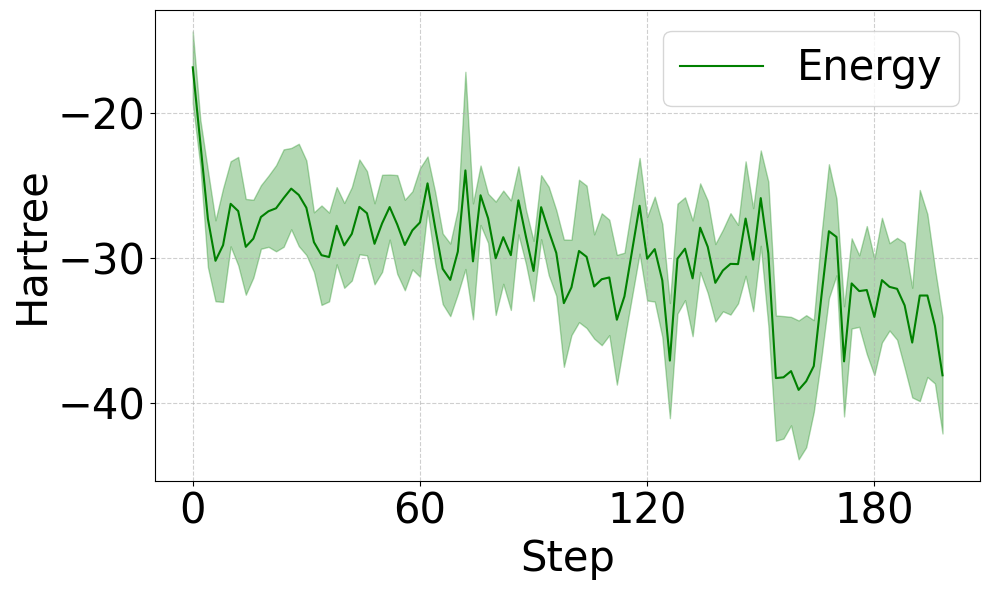

In [61]:
plot_rewards_with_std(
    combined_df,
    property="energy",
    steps=2,
    save_path_base=exp_path / Path("energy")
)

Saved: /Users/svlg/MasterThesis/v02/aa_experiments/00_paper/dipole.pdf
Saved: /Users/svlg/MasterThesis/v02/aa_experiments/00_paper/dipole.png


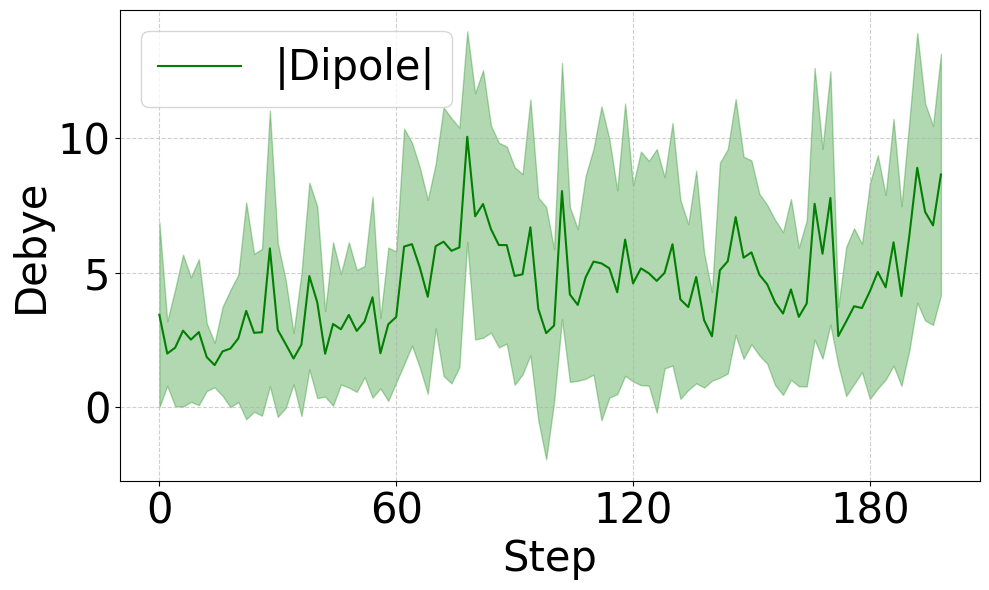

In [62]:
plot_rewards_with_std(
    combined_df,
    property="dipole",
    steps=2,
    save_path_base=exp_path / Path("dipole")
)

In [ ]:
plot_rewards_with_std(
    combined_df,
    property="constraint_violations",
    steps=2,
    # save_path_base=exp_path / Path("constraint_plot")
)

In [ ]:
assert False

In [64]:
!scp -r sgutjahr@euler.ethz.ch:~/MasterThesis/ConstraintGenerationMols/aa_experiments/sweep_dipole_energy_18/h6524rej/05-26-08/samples/ /Users/svlg/MasterThesis/v02/aa_experiments

samples_0.bin                                 100%  457KB   1.4MB/s   00:00    
samples_1.bin                                 100%  456KB   2.4MB/s   00:00    
samples_2.bin                                 100%  453KB   2.6MB/s   00:00    
samples_3.bin                                 100%  474KB   2.7MB/s   00:00    
samples_4.bin                                 100%  448KB   2.5MB/s   00:00    
samples_5.bin                                 100%  496KB   2.8MB/s   00:00    


In [ ]:
results = np.load(exp_path / Path("results.npz"))
results

In [ ]:
df = pd.DataFrame({
    "rewards": results["rewards"],
    "rewards_std": results["rewards_std"],
    "reward_median": results["reward_median"],
    "num_invalids": results["num_invalids"],
    "losses": results["losses"]
})

In [ ]:
# df["rewards"] = - df["rewards"]
# df["reward_median"] = - df["reward_median"]

In [ ]:
results["rewards_std"]

In [ ]:
title = f"Adjoint Matching with reward: {function}"
y_axis = f"||{function}|| (Debye)"
steps = 2
plot_rewards_with_std(df, str(exp_path) + f"/{function}", title=title, y_axis=y_axis, steps=steps)

In [ ]:
df["rewards"].iloc[-1], df["rewards_std"].iloc[-1]

In [ ]:
rewards = results["rewards"]
rewards_std = results["rewards_std"]
reward_median = results["reward_median"]
num_invalids = results["num_invalids"]

In [ ]:
root = "/Users/svlg/MasterThesis/v02/aa_experiments/"
experiment = "aug_lag_const_engergy_sweep"
exp_path = Path(root) / Path(experiment)

In [ ]:
sweep = "Sweep: 8mpky5no -"

In [ ]:
dfs = []
options = ["mean" , "std", "median"]
for p in options:
    tmp_df = pd.read_csv(exp_path / Path(f"constraint_{p}.csv"))
    tmp_name = sweep + f" constraint_{p}"
    if p == "mean":
        tmp_name = sweep + f" constraint"
    tmp = tmp_df[tmp_name] 
    dfs.append(tmp)

df = pd.concat(dfs, axis=1)
df.columns = options

In [ ]:
df

In [ ]:
df["mean"] = - df["mean"]
df["median"] = - df["median"]

In [ ]:
exp_path

In [ ]:
def plot_rewards_with_std(results, save_path_base, title, y_axis, steps, updates):
    """
    Plots mean and median rewards with standard deviation shading.
    
    Parameters:
        results (dict): Must contain keys "rewards", "rewards_std", "reward_median"
        save_path_base (str): Base file path (without extension) to save the plot
    """
    rewards = results["mean"]
    rewards_std = results["std"]
    reward_median = results["median"]

    x = np.arange(0, steps * len(rewards), steps)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(x, rewards, label="Mean", color="green", zorder=2)
    ax.fill_between(x, rewards - rewards_std, rewards + rewards_std, 
                    color="green", alpha=0.3, label="±1 Std Dev", zorder=1)
    ax.plot(x, reward_median, label="Median", color="black", linestyle="--", zorder=2)

    ax.set_title(f"{title}", fontsize=18)
    ax.set_xlabel("Step", fontsize=14)
    ax.set_ylabel(f"{y_axis}", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.6)

    v_bar_stes = 500//updates
    x_vbar = x[::v_bar_stes//steps]
    print(x_vbar)
    for tmp in x_vbar:
        ax.axvline(x=tmp, color='blue', linestyle='--', alpha=0.5, zorder=0)

    plt.tight_layout()

    # Save as both PDF and PNG
    for ext in [".pdf", ".png"]:
        full_path = f"{save_path_base}{ext}"
        plt.savefig(full_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {full_path}")

    plt.show()

In [ ]:
title = f"Full Algorithm"
y_axis = f"Energy (Hartree)"
steps = 2
updates = 20
plot_rewards_with_std(df, str(exp_path) + "/aug_lag", title = title, y_axis = y_axis, steps=steps, updates=updates)

In [ ]:
tmp_df = pd.read_csv(exp_path / Path(f"constraint_violations.csv"))
tmp_df = tmp_df.drop(columns=["Step"])
tmp_df = tmp_df.rename(columns={
    "Sweep: 8mpky5no - constraint_violations": "violations",
    "Sweep: 8mpky5no - constraint_violations__MIN": "min",
    "Sweep: 8mpky5no - constraint_violations__MAX": "max"
})
tmp_df["std"] = (tmp_df["max"] - tmp_df["min"])/2

In [ ]:
tmp_df

In [ ]:
def plot_rewards_with_std(results, save_path_base, title, y_axis, steps, updates):
    """
    Plots mean and median rewards with standard deviation shading.
    
    Parameters:
        results (dict): Must contain keys "rewards", "rewards_std", "reward_median"
        save_path_base (str): Base file path (without extension) to save the plot
    """
    rewards = results["violations"]
    rewards_max = results["max"]
    rewards_min = results["min"]

    x = np.arange(0, steps * len(rewards), steps)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(x, rewards, label="Mean", color="green", zorder=2)
    ax.fill_between(x, rewards_max, rewards_min,
                    color="green", alpha=0.3, label="max-min", zorder=1)

    ax.set_title(f"{title}", fontsize=18)
    ax.set_xlabel("Step", fontsize=14)
    ax.set_ylabel(f"{y_axis}", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.6)

    v_bar_stes = 500//updates
    x_vbar = x[::v_bar_stes//steps]
    print(x_vbar)
    for tmp in x_vbar:
        ax.axvline(x=tmp, color='blue', linestyle='--', alpha=0.5, zorder=0)

    plt.tight_layout()

    # Save as both PDF and PNG
    for ext in [".pdf", ".png"]:
        full_path = f"{save_path_base}{ext}"
        plt.savefig(full_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {full_path}")

    plt.show()

In [ ]:
title = f"Full Algorithm - constraint violations"
y_axis = f""
steps = 2
updates = 20
plot_rewards_with_std(tmp_df, str(exp_path) + "/constraint_violations", title = title, y_axis = y_axis, steps=steps, updates=updates)

In [ ]:
metrics = [
    "constraint", 
    "constraint_violations",
    "kl"
]
if experiment == "6_target_point" or experiment == "7_base_line":
    metrics.insert(0, "reward")

In [ ]:
dfs = []
for metric in metrics:
    path = exp_path / Path(f"{metric}.csv")
    print(path)
    if path.exists():
        df = pd.read_csv(path)
        dfs.append(df)
len(dfs)

In [ ]:
dfs[0].head()

In [ ]:
exclude_col = ["simple"] if experiment == "2_functional_type" else None
log_y = False if experiment in ["5_bound","6_target_point", "7_base_line"] else True
experiment_key = experiment[2:]
experiment_key = experiment_key if experiment_key != "base_line" else "target_point"

In [ ]:
plot_experiment_frames(
    dataframes=dfs,
    metrics=metrics,
    experiment_key=experiment_key,
    title_name="",
    log_y=log_y,
    save_freq=15,
    # save_path = f"{root}{dataset}/aug_lag/0_sweeps/{experiment}",
    subsample=2,
    exclude_col=exclude_col,
)


In [ ]:
experiments = [
    "0_reward_lambda", 
    "1_batch_size",
    "2_functional_type",
    "3_eta",
    "4_rho_init",
    "5_bound",
    "6_target_point",
    "7_base_line"
]

In [ ]:
for experiment in experiments:
    print(experiment)
    exp_path = Path(root) / Path(dataset) / Path("aug_lag") / Path("0_sweeps") / Path(experiment)

    metrics = ["constraint", "constraint_violations", "kl"]
    if experiment == "6_target_point" or experiment == "7_base_line":
        metrics.insert(0, "reward")

    dfs = []
    for metric in metrics:
        path = exp_path / Path(f"{metric}.csv")
        if path.exists():
            df = pd.read_csv(path)
            dfs.append(df)

    exclude_col = ["simple"] if experiment == "2_functional_type" else None
    log_y = False if experiment in ["5_bound","6_target_point", "7_base_line"] else True
    experiment_key = experiment[2:]
    experiment_key = experiment_key if experiment_key != "base_line" else "target_point"

    prefix = "sg" if dataset == "simple_gaussian" else "mog"
    save_path = f"{root}{dataset}/aug_lag/0_sweeps/{prefix}_{experiment[2:]}"
    
    plot_experiment_frames(
        dataframes = dfs,
        metrics = metrics,
        experiment_key = experiment_key,
        title_name = "",
        log_y = log_y,
        save_freq = 15,
        save_path = save_path,
        subsample = 2,
        exclude_col = exclude_col,
        pdf = True
    )


In [ ]:
save_path

In [ ]:
constraint = dfs[0]
constraint.head()

In [ ]:
constraint.iloc[500]

In [ ]:
constraint_vio = dfs[1]
constraint_vio.head()

In [ ]:
constraint_vio.iloc[1]

In [ ]:
constraint_vio.iloc[500]

In [ ]:
!scp -r /Users/svlg/MasterThesis/v01_constraint_bandits/const_sampler sgutjahr@euler.ethz.ch:~/MasterThesis/ConstraintBanditsSynthetic/const_sampler